#### Imports


In [97]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal

#### Definitions

We define the discrete gradient operator $D$ and its adjoint $D^*$.

In [98]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]

In [99]:
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

We regularize the strongly convex primal problem by adding the corresponding LASSO term :
$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= f(x)+ g(Dx) + \alpha \lVert x \rVert_{1} =\frac{1}{2}\|x-y\|^2+\lambda\|Dx\|_{1,2} + \alpha \lVert x \rVert_{1}$$


Which is equivalent to

$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= \frac{1}{2}\|x-y\|^2+ h(x)$$

Where :

$$ h(x) = f(x) + g(x) $$
$$ f(x) = \lambda\|Dx\|_{1,2} = \lambda \cdot \text{TV(x)} $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

Therefore, we have to adapt the proximal operator for $h$, knowing that :

$$ x = \text{prox}_{\gamma h^*}(x) + \gamma \text{prox}_{h/\gamma}(x/\gamma) $$

Moreover, we will first assume that

$$ \text{prox}_{\gamma h}(x) =  \text{prox}_{\gamma g}(x) \circ \text{prox}_{\gamma f}(x)  $$

Thus yielding


$$\begin{aligned}

\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) \\
= u - \gamma \text{prox}_{g / \gamma}(\text{prox}_{f / \gamma}(u/\gamma) ) 
\end{aligned}$$

With

$$\text{prox}_{g/\gamma}(u) = \text{defined numerically, or by } \ \text{sign}(u) \cdot max\{0;|u| - \alpha/\gamma\} $$

Regarding $\text{prox}_{f/\gamma}(u/\gamma)$, we know that for $f(Dx) =  \lambda \ \lVert Dx \rVert_{1,2} $, we have 

$$\big(\text{prox}_{\gamma f^*}(u)\big)_{n_1,n_2}=\frac{1}{\max(\|u_{n_1,n_2}\|_2/\lambda,1)}u_{n_1,n_2}\in\mathbb{R}^2,\quad\forall (n_1,n_2).$$ 

Using the Moreau identity once again, and in the context of our newly defined problem, we can write 

$$

 \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \big(\text{prox}_{\gamma f^*}(u)\big) 
$$


$$
\Rightarrow \text{prox}_{f/\gamma}(u/\gamma) = \frac{u - \big(\text{prox}_{\gamma f^*}(u)\big)}{\gamma} 
$$

Knowing that $\big(\text{prox}_{\gamma f^*}(u)\big)$ is implemented as :


In [100]:
def prox_f_conj (u, Lambda) :
    return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

We can implement this proximal operator as :

In [101]:
def proximal_TV_operator(u,gamma,Lambda) : 
    return( (u - prox_f_conj(u,Lambda)) / gamma)

#def proximal_TV_operator(x, gamma, Lambda):
#    """  
#    Applies the proximal operator of the TV term.
#    
#    Parameters
#    ----------
#    x : Multidim. array to which we apply the proximal operator. (np.ndarray)
#    gamma : The usual gamma term (float)
#    Lambda : Multiplicative coefficient of the TV term (float)
#
#    Returns 
#    ---------
#    prox_result : The resulting ndarray from the application of the "TV" proximal operator.
#
#    """
#    #Defining the TV operator (that's how pyproximal works apparently)
#    TV = pyproximal.TV(dims=x.shape, sigma=Lambda)
#    try:
#        #Apply the TV proximal operator to x/gamma, and reshape the result to what we need
#        prox_result = TV.prox((x / gamma),2).reshape((512,512,2))
#        #print(f"TV.prox result shape: {result.shape}")
#        return prox_result
#    except Exception as e:
#        print(f"Error in TV.prox: {e}")
#        raise

For the proximal operator of $g$, we can implement it as :

In [102]:
def proximal_operator_lasso(u, alpha,gamma):
    """  
    Applies the proximal operator of the L1 norm.
    
    Parameters
    ----------
    u : Multidim. array to which we apply the proximal operator. (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)

    Returns 
    ---------
    The resulting ndarray from the application of the L1 norm proximal operator.

    """
    #return np.sign(u) * np.maximum(abs(u) - alpha,0)
    L1 = pyproximal.L1(sigma=alpha)
    try:
        #Apply the TV proximal operator to u, scaled by 1/gamma, then reshape the result to what we need
        prox_result = L1.prox(u,1/gamma).reshape((512,512,2))
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

We can then add both into the proximal operator of $h$ :

In [103]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:
        #Application of the proximal 'TV' operator...
        prox_tv = proximal_TV_operator(redef_u, gamma, Lambda)
        #... And successive application of the proximal 'lasso' operator
        prox_lasso = proximal_operator_lasso(prox_tv, alpha, gamma)
        proximal_composition = gamma * prox_lasso

        return redef_u - proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

## Implementation + trying out the revised algorithm

We then implement this newly defined proximal operator into the Chambolle's algorithm, and try it out on the baseline Ascent image, from `scipy.misc`.

In [117]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


#### Generating the image + its noised version

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\3031940516.py:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  xsharp = misc.ascent()


Text(0.5, 1.0, 'Noisy version of Lena')

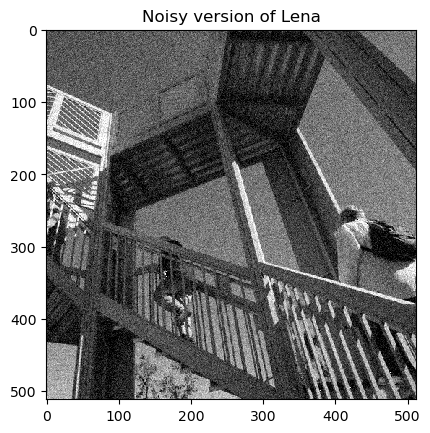

In [121]:
'''Generating input :'''
xsharp = misc.ascent()
xsharp = xsharp.astype(np.float32) #create image
'''Add Noise'''
(N1,N2) = np.shape(xsharp)
noiselevel = 20
noised_image = xsharp + noiselevel * np.random.randn(N1,N2)
plt.imshow(noised_image, interpolation='nearest', cmap= plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title('Noisy version of Lena')

In [136]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

denoised_image_nolasso,_,_  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
denoised_image_lasso,_,_ = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

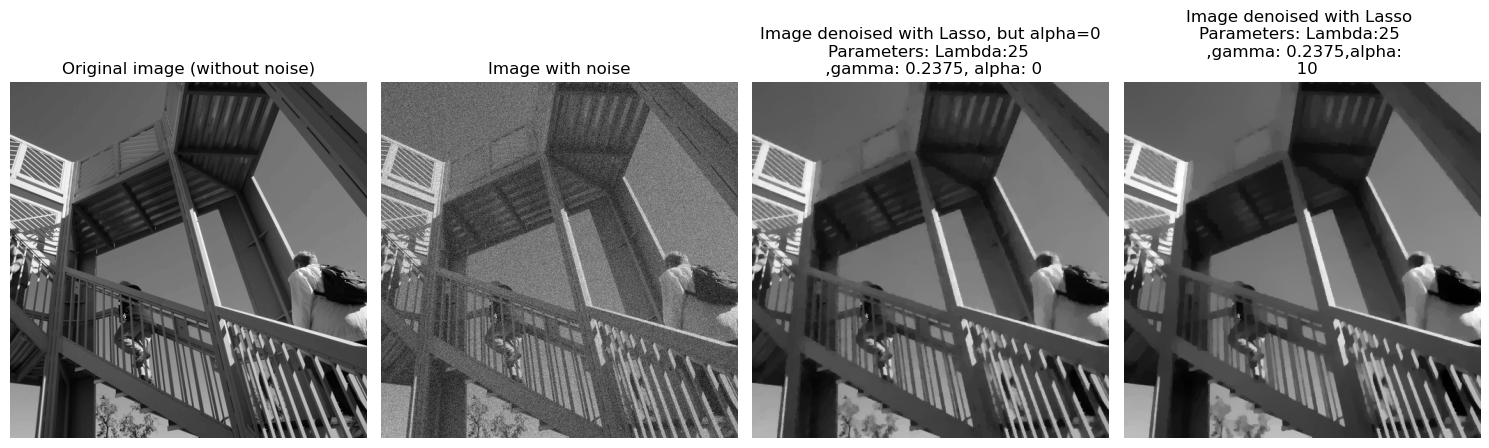

In [137]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(denoised_image_nolasso, cmap='gray')
axs[2].set_title(f"Image denoised with Lasso, but alpha=0\nParameters: Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[3].imshow(denoised_image_lasso, cmap='gray')
axs[3].set_title(f"Image denoised with Lasso \nParameters: Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Trying to revert the composition of proximal operators

Here we implement the exact same algorithm as before, with the sole exception of modifying the composition of proximal operators in the Chambolle algorithm iterations. This means that, with


$$ f(x) = \lambda\|Dx\|_{1,2} = \lambda \cdot \text{TV(x)} $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

We obtain :

$$\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) = u - \gamma \text{prox}_{f / \gamma}(\text{prox}_{g / \gamma}(u/\gamma) ).$$

To decipher this composition of proximal iterators, we need $\text{prox}_{\gamma f^*}(u)$ to appear, as it is the one we have. Using the Moreau decomposition once more, we can write


$$ \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \text{prox}_{f^*}(u)
$$ 

By then setting $v = \frac{u}{\gamma}$, we obtain

$$ \gamma \text{prox}_{f/\gamma}(v) = \gamma v - \text{prox}_{f^*}(\gamma v)
$$ 

We thus obtain, by replacing $v$ with $\text{prox}_{g / \gamma}(u/\gamma)$


$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u - ( \gamma\text{prox}_{g / \gamma}(u/\gamma) - \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma))) $$

$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u -  \gamma\text{prox}_{g / \gamma}(u/\gamma) + \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma)) $$



In [129]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:

        prox_lasso = proximal_operator_lasso(redef_u/gamma, alpha,gamma)

        proximal_composition = prox_f_conj(gamma*prox_lasso,Lambda)

        return redef_u - gamma*prox_lasso + proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

In [131]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

revert_denoised_image_nolasso,_,_  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
revert_denoised_image_lasso,_,_ = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

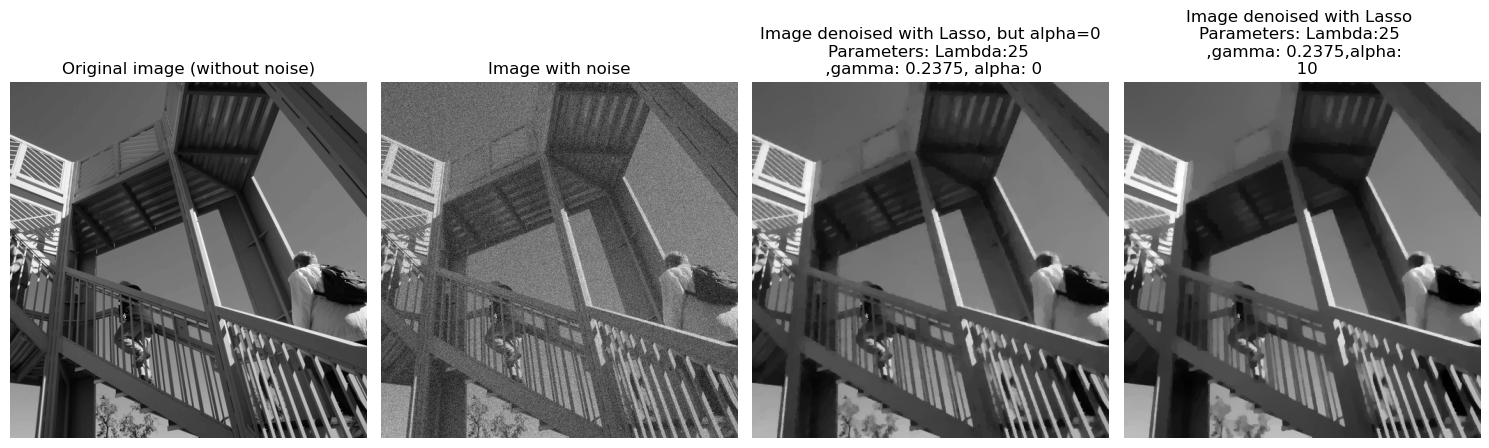

In [132]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(revert_denoised_image_nolasso, cmap='gray')
axs[2].set_title(f"Image denoised with Lasso, but alpha=0\nParameters: Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[3].imshow(revert_denoised_image_lasso, cmap='gray')
axs[3].set_title(f"Image denoised with Lasso \nParameters: Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Trying to optimize hyperparameters

In [111]:
#from sklearn.model_selection import ParameterGrid
#from skimage.metrics import peak_signal_noise_ratio as psnr
#
#
#Lambda_values = np.linspace(10, 100, 10)  
#gamma_values = np.linspace(0.1, 1.9/8, 10)  
#alpha_values = np.linspace(0, 100, 10)  
#
#param_grid = {
#    'Lambda': Lambda_values,
#    'gamma': gamma_values,
#    'alpha': alpha_values,
#}
#
#param_combinations = list(ParameterGrid(param_grid))
#
#best_psnr = -np.inf
#best_params = None
#best_xdenoised = None
#
#psnr_values = []
#
#for params in param_combinations:
#    Lambda = params['Lambda']
#    gamma = params['gamma']
#    alpha = params['alpha']
#
#    xdenoised, Ep_array, Ed_array = chambolle_algorithm(noised_image, Lambda, gamma, alpha, nbiter, homemade=True)
#    
#    # Assuming `original_image` is the ground truth image without noise
#    #print(xdenoised,xsharp)
#    current_psnr = psnr(xsharp, xdenoised,data_range=255)
#    psnr_values.append((Lambda, gamma, alpha, current_psnr))
#    
#    if current_psnr > best_psnr:
#        best_psnr = current_psnr
#        best_params = params
#        best_xdenoised = xdenoised
#
#print(f"Best Parameters: {best_params}")
#print(f"Best PSNR: {best_psnr}")
#
## Visualize the best denoised image
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(9,9))
#plt.imshow(best_xdenoised, cmap='gray')
#plt.title(f"Best Denoised Image\nParameters: {best_params}")
#plt.show()
#
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#
## Unpack psnr values for plotting
#Lambda_vals, gamma_vals, alpha_vals, psnr_vals = zip(*psnr_values)
#
#sc = ax.scatter(Lambda_vals, gamma_vals, alpha_vals, c=psnr_vals, cmap='viridis')
#ax.set_xlabel('Lambda')
#ax.set_ylabel('gamma')
#ax.set_zlabel('alpha')
#plt.colorbar(sc, label='PSNR')
#plt.title('PSNR for different parameter combinations')
#plt.show()